# Project: Wrangling and Analyze Data

## Table of Content

[Introduction](#intro)<br>
[Importing Libraries and Modules](#libraries)<br>
[Data Gathering](#gathering)<br>
    1. [Directly download the WeRateDogs Twitter archive data](#archivedata)<br>
    2. [Use the Requests library to download the tweet image prediction](#predictiondata)<br>
    3. [Use the Tweepy library to query additional data via the Twitter API](#tweepydata)<br>
[Assessing Data](#assess)<br>
    1. [Visual & Programmatic Assessment](#visual)<br>
    2. [Quality issues](#quality)<br>
    3. [Tidiness issues](#tidiness)<br>
[Cleaning Data](#clean)<br>
    1. [Making Copies of Original Data](#copies)<br>
    2. [Cleaning Quality Issue](#cleanquality)<br>
    3. [Cleaning Tidiness Issues](#cleantidy)<br>
[Storing Data](#store)<br>
[Analyzing and Visualizing Data](#analysis)<br>
    1. [What are the top 10 most popular dog breeds?](#insight1)<br>
    2. [Which is the common source of tweets?](#insight2)<br>
    3. [Which year and month had the most tweet?](#insight3)<br>
    4. [Correlation between Retweets and Favorites counts](#insight4)<br>
    5. [Correlation between Ratings and Favorites counts](#insight5)<br>
    6. [Correlation between Ratings and Retweet counts](#insight6)<br>
[References / Materials Consulted](#ref)<br>


## Introduction<a id="intro"></a>
WeRateDogs is a Twitter account with millions of followers that rates images and humorous comments about man's best friend (dogs). These ratings almost always have a denominator of 10, and the numerators vary but are almost always greater than 10. Udacity received a downloaded Twitter archive for use in data wrangling projects.<br> 
For this project, the data will be gathered from three different sources i.e., __the WeRateDogs Twitter archive__, __tweet image prediction__, and __Twitter API__ datasets. Gleaned data will be visually and programmatically _assessed_, _cleaned_, and _analyzed_ to draw some insights.<br>

## Importing Libraries and Modules<a id="libraries"></a><br>
For this project, the following libraries will be needed and therefore will be imported: 
`pandas`
`numpy`
`request`
`matplotlib`
`tweepy`
`seaborn`
`json`
`csv`

In [1]:
# inporting libraries and modules for the analysis

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import io
import json
from pprint import pprint
%matplotlib inline

## Data Gathering
<a id="gathering"></a>
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.<br>
#### 1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)<a id="archivedata"></a>

In [2]:
# downloading the WeRateDogs Twitter archive data in a dataframe as 'archive'
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [4]:
# taking a glimpse of the 'archive' data structured
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### 2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)<a id="predictiondata"></a>

In [5]:
# downloading the tweet image prediction date using the request (get) function into a dataframe as 'prediction'

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv').content
prediction = pd.read_csv(io.StringIO(r.decode('utf-8')), sep = '\t')
prediction.to_csv('prediction.tsv')
print('prediction shape', prediction.shape)
prediction.head()
prediction.to_csv('image_predictions.tsv', sep='\t', index = False) # save DF to a file 

prediction shape (2075, 12)


In [6]:
# taking a glimpse of the 'archive' data structured
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)<a id="tweepydata"></a>

In [7]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Rate limit reached. Sleeping for: 297


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Success
1154: 725729321944506368
Success
1155: 725458796924002305
Success
1156: 724983749226668032
Success
1157: 724771698126512129
Success
1158: 724405726123311104
Success
1159: 724049859469295616
Success
1160: 724046343203856385
Success
1161: 724004602748780546
Success
1162: 723912936180330496
Success
1163: 723688335806480385
Success
1164: 723673163800948736
Success
1165: 723179728551723008
Success
1166: 722974582966214656
Success
1167: 722613351520608256
Success
1168: 721503162398597120
Success
1169: 721001180231503872
Success
1170: 720785406564900865
Success
1171: 720775346191278080
Success
1172: 720415127506415616
Success
1173: 720389942216527872
Success
1174: 720340705894408192
Success
1175: 720059472081784833
Success
1176: 720043174954147842
Success
1177: 719991154352222208
Success
1178: 719704490224398336
Success
1179: 719551379208073216
Success
1180: 719367763014393856
Success
1181: 719339463458033665
Success
1182: 719332531645071360
Success
1183: 718971898235854848
Success
11

Success
1403: 699423671849451520
Success
1404: 699413908797464576
Success
1405: 699370870310113280
Success
1406: 699323444782047232
Success
1407: 699088579889332224
Success
1408: 699079609774645248
Success
1409: 699072405256409088
Success
1410: 699060279947165696
Success
1411: 699036661657767936
Success
1412: 698989035503689728
Success
1413: 698953797952008193
Success
1414: 698907974262222848
Success
1415: 698710712454139905
Success
1416: 698703483621523456
Success
1417: 698635131305795584
Success
1418: 698549713696649216
Success
1419: 698355670425473025
Success
1420: 698342080612007937
Success
1421: 698262614669991936
Success
1422: 698195409219559425
Success
1423: 698178924120031232
Success
1424: 697995514407682048
Success
1425: 697990423684476929
Success
1426: 697943111201378304
Success
1427: 697881462549430272
Success
1428: 697630435728322560
Success
1429: 697616773278015490
Success
1430: 697596423848730625
Success
1431: 697575480820686848
Success
1432: 697516214579523584
Success
14

Success
1652: 683498322573824003
Success
1653: 683481228088049664
Success
1654: 683462770029932544
Success
1655: 683449695444799489
Success
1656: 683391852557561860
Success
1657: 683357973142474752
Success
1658: 683142553609318400
Success
1659: 683111407806746624
Success
1660: 683098815881154561
Success
1661: 683078886620553216
Success
1662: 683030066213818368
Success
1663: 682962037429899265
Success
1664: 682808988178739200
Success
1665: 682788441537560576
Success
1666: 682750546109968385
Success
1667: 682697186228989953
Success
1668: 682662431982772225
Success
1669: 682638830361513985
Success
1670: 682429480204398592
Success
1671: 682406705142087680
Success
1672: 682393905736888321
Success
1673: 682389078323662849
Success
1674: 682303737705140231
Success
1675: 682259524040966145
Success
1676: 682242692827447297
Success
1677: 682088079302213632
Success
1678: 682059653698686977
Success
1679: 682047327939461121
Success
1680: 682032003584274432
Success
1681: 682003177596559360
Success
16

Rate limit reached. Sleeping for: 301


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
2062: 671166507850801152
Success
2063: 671163268581498880
Success
2064: 671159727754231808
Success
2065: 671154572044468225
Success
2066: 671151324042559489
Success
2067: 671147085991960577
Success
2068: 671141549288370177
Success
2069: 671138694582165504
Success
2070: 671134062904504320
Success
2071: 671122204919246848
Success
2072: 671115716440031232
Success
2073: 671109016219725825
Success
2074: 670995969505435648
Success
2075: 670842764863651840
Success
2076: 670840546554966016
Success
2077: 670838202509447168
Success
2078: 670833812859932673
Success
2079: 670832455012716544
Success
2080: 670826280409919488
Success
20

Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
2311: 666786068205871104
Success
2312: 666781792255496192
Success
2313: 666776908487630848
Success
2314: 666739327293083650
Success
2315: 666701168228331520
Success
2316: 666691418707132416
Success
2317: 666649482315059201
Success
2318: 666644823164719104
Success
2319: 666454714377183233
Success
2320: 666447344410484738
Success
2321: 666437273139982337
Success
2322: 666435652385423360
Success
2323: 666430724426358785
Success
2324: 666428276349472768
Success
2325: 666421158376562688
Success
2326: 666418789513326592
Success
2327: 666411507551481857
Success
2328: 666407126856765440
Success
2329: 666396247373291520
Success
23

In [8]:
# From the text file read the JSON data
tweets = []
for line in open('tweet_json.txt', 'r'):
    tweets.append(json.loads(line))
#print out one json object for further reference 
tweets[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [9]:
# creating a list of data from tweet_json.txt
list_tweets = []
for json_data in tweets:
    list_tweets.append({'id' : json_data['id'],
                       'retweet_count': int(json_data['retweet_count']),
                       'favorite_count' : int(json_data['favorite_count'])})

In [10]:
# creating a Dataframe of the JSON data obtained as 'tweets_api'
tweets_api = pd.DataFrame(list_tweets, columns = ['id', 'retweet_count' , 'favorite_count'])

In [11]:
# Checking out the obatined DataFrame
tweets_api.head()

,id,retweet_count,favorite_count
0,892420643555336193,6956,33652
1,892177421306343426,5263,29185
2,891815181378084864,3463,21951
3,891689557279858688,7181,36728
4,891327558926688256,7706,35130


## Assessing Data<a id="assess"></a>
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### 1. Visual & Programmatic Assessment <a id="visual"></a>

In [12]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [13]:
archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1208,715704790270025728,NaN,NaN,2016-04-01 00:58:13 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Bentley. He gives kisses back. 11/10 p...,NaN,NaN,NaN,https://vine.co/v/ijAlDnuOD0l,11,10,Bentley,None,None,None,None
2252,667801013445750784,NaN,NaN,2015-11-20 20:25:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMIGOD 12/10 https://t.co/SVMF4Frf1w,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667801013...,12,10,None,None,None,None,None
1518,690932576555528194,NaN,NaN,2016-01-23 16:22:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Buddy. He's testing out the water. Suc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690932576...,12,10,Buddy,None,None,None,None
1926,674053186244734976,NaN,NaN,2015-12-08 02:29:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. Yes he is aware of the spoon'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674053186...,10,10,Stanley,None,None,None,None
502,813081950185472002,NaN,NaN,2016-12-25 18:00:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Baron. He's officially festive as h*ck...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813081950...,11,10,Baron,None,None,None,None
964,750506206503038976,NaN,NaN,2016-07-06 01:46:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Malcolm. He's absolutely terrified of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750506206...,8,10,Malcolm,None,None,pupper,None
267,841680585030541313,NaN,NaN,2017-03-14 16:01:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's a dragon slayer. Feared b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841680585...,12,10,Penny,None,None,None,None
1008,747594051852075008,NaN,NaN,2016-06-28 00:54:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Again w the sharks guys. This week is about do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747594051...,11,10,None,None,None,None,None
1753,678800283649069056,NaN,NaN,2015-12-21 04:52:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with some mean tan lines. Snaz...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678800283...,12,10,None,None,None,pupper,None
434,820494788566847489,NaN,NaN,2017-01-15 04:56:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We are proud to support @LoveYo...,8.203146e+17,4.196984e+09,2017-01-14 17:00:24 +0000,"https://www.loveyourmelon.com/pages/ourstory,h...",14,10,None,None,None,None,None


In [14]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [16]:
sum(archive.duplicated())

0

In [17]:
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [18]:
archive.rating_numerator.value_counts().head(25)

12     558
11     464
10     461
13     351
9      158
8      102
7       55
14      54
5       37
6       32
3       19
4       17
2        9
1        9
75       2
15       2
420      2
0        2
80       1
144      1
17       1
26       1
20       1
121      1
143      1
Name: rating_numerator, dtype: int64

In [19]:
archive.in_reply_to_status_id.value_counts().head()

6.671522e+17    2
8.862664e+17    1
6.920419e+17    1
6.827884e+17    1
6.842229e+17    1
Name: in_reply_to_status_id, dtype: int64

In [20]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [21]:
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [22]:
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [23]:
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [24]:
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [25]:
archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [26]:
archive.rating_denominator.nunique()

18

In [27]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [28]:
archive.name.nunique()

957

In [29]:
prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [32]:
prediction.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [33]:
prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1667,812781120811126785,https://pbs.twimg.com/media/C0eUHfWUAAANEYr.jpg,1,bull_mastiff,0.989316,True,boxer,0.007043,True,French_bulldog,0.001740,True
754,688211956440801280,https://pbs.twimg.com/ext_tw_video_thumb/68821...,1,bannister,0.369449,False,four-poster,0.105307,False,shoji,0.098767,False
1088,718971898235854848,https://pbs.twimg.com/media/CfpNGTHUIAAA8XC.jpg,1,golden_retriever,0.140394,True,Saint_Bernard,0.118769,True,Labrador_retriever,0.075492,True
1020,710153181850935296,https://pbs.twimg.com/media/Cdr4jO2UAAAIo6W.jpg,2,cowboy_hat,0.979053,False,sombrero,0.010682,False,cocker_spaniel,0.002713,True
142,668614819948453888,https://pbs.twimg.com/media/CUdloW8WEAAxB_Y.jpg,1,bustard,0.380772,False,pelican,0.100554,False,crane,0.084713,False
1331,757611664640446465,https://pbs.twimg.com/media/CoOTyXJXEAAtjs9.jpg,1,bluetick,0.829259,True,beagle,0.145358,True,Walker_hound,0.019595,True
808,692142790915014657,https://pbs.twimg.com/media/CZr8LvyXEAABJ9k.jpg,3,toy_poodle,0.670068,True,teddy,0.190898,False,miniature_poodle,0.032178,True
1483,781251288990355457,https://pbs.twimg.com/media/CteP5H5WcAEhdLO.jpg,2,Mexican_hairless,0.887771,True,Italian_greyhound,0.030666,True,seat_belt,0.026730,False
1265,749317047558017024,https://pbs.twimg.com/ext_tw_video_thumb/74931...,1,wire-haired_fox_terrier,0.155144,True,Lakeland_terrier,0.108382,True,buckeye,0.074617,False
984,707420581654872064,https://pbs.twimg.com/media/CdFDQVgWIAArslx.jpg,1,ram,0.518215,False,kuvasz,0.149391,True,Great_Pyrenees,0.106003,True


In [34]:
sum(prediction.duplicated())

0

In [35]:
sum(prediction['jpg_url'].duplicated())

66

In [36]:
prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [37]:
prediction.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [38]:
prediction.p1.nunique()

378

In [39]:
prediction.p2.nunique()

405

In [40]:
prediction.p3.nunique()

408

In [41]:
tweets_api.head(5)

,id,retweet_count,favorite_count
0,892420643555336193,6956,33652
1,892177421306343426,5263,29185
2,891815181378084864,3463,21951
3,891689557279858688,7181,36728
4,891327558926688256,7706,35130


In [42]:
tweets_api.tail(5)

,id,retweet_count,favorite_count
2322,666049248165822465,36,88
2323,666044226329800704,114,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112
2326,666020888022790149,419,2280


In [43]:
tweets_api.sample(10)

,id,retweet_count,favorite_count
437,818307523543449600,7410,0
1281,707059547140169728,618,2394
519,806620845233815552,5121,0
848,761334018830917632,1332,4809
976,747816857231626240,1051,4485
148,862096992088072192,19876,65973
2205,668190681446379520,171,574
73,878316110768087041,5493,0
1933,673355879178194945,490,1334
1139,721503162398597120,1637,4209


In [44]:
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [45]:
tweets_api.describe()

,id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2454.584873,7017.047701
std,6.820795e+16,4156.517912,10903.483161
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.000000,1217.500000
50%,7.178418e+17,1143.000000,3034.000000
75%,7.986547e+17,2841.500000,8555.000000
max,8.924206e+17,70179.000000,143996.000000


In [46]:
tweets_api.retweet_count.value_counts()

468     6
406     6
50      6
520     5
326     5
       ..
2447    1
3043    1
3986    1
935     1
419     1
Name: retweet_count, Length: 1655, dtype: int64

In [47]:
tweets_api.favorite_count.value_counts()

0        160
3206       3
1725       3
924        3
392        3
        ... 
6016       1
29138      1
7110       1
5827       1
2280       1
Name: favorite_count, Length: 1977, dtype: int64

In [48]:
sum(tweets_api.duplicated())

0

In [49]:
tweets_api.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

### 2. Quality issues<a id="quality"></a>

_Below are some of the identified data quality issues that need to cleaned_<br>

**archive**<br>
1.	only original tweets are needed for this project, these columns retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp have some entries therefore are retweets<br>
2.	retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp variables have a lot of missing data and, need to be dropped<br>
3.	the name variable has many non-dog names such as 'None’, ‘a’, ‘all’, ‘an’, ‘by’, ‘his’, ‘just’, ‘my’, ‘not’, ‘such’, ‘the’, ‘this’, ‘very’<br>
4.	the '+0000' in the timestamp column is redundant information<br>
5.	the timestamp should be converted to datetime<br>
6.	the URLs in the source column contain the tweet sources embedded in them, and are to be extracted<br>
7.	some rating denominator entries are greater or less than the usual value of 10<br>
8.  the retweet_count and favorite_count columns have a few NaN values<br>

**prediction**<br>

9.	the values in the p1, p2 and p3 columns characters like '-', '_'<br>
10.	breed names in columns p1, p2 and p3 begin with lowercase letters<br>
11.	duplicate values in column jpg_url<br>

### 3. Tidiness issues<a id="tidiness"></a>

_Below are some of the identified data tidiness issues that need to cleaned_<br>

12.	Variables doggo, floofer, pupper and puppo will be combined into a new column 'stage' and then the redundant variables - doggo, floofer, pupper and puppo will be dropped<br>
13.	For the purpose of this project, I would create a two new columns dog_type and confidence_level, which will be filled with dog breed names from predictions that were true for p1, p2 and p3<br>
14.	Information about one type of observational unit (tweets) is spread across three different files/dataframes. Datasets spread across the three datasets "archive", "prediction" and "tweets_api" into one<br>

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

### 1. Making Copies of Original Data<a id="copies"></a>

In [50]:
# Make copies of original pieces of data

archive_original = archive.copy()
prediction_original = prediction.copy()
tweets_api_original = tweets_api.copy()

In [51]:
# checking the copied data
tweets_api_original

,id,retweet_count,favorite_count
0,892420643555336193,6956,33652
1,892177421306343426,5263,29185
2,891815181378084864,3463,21951
3,891689557279858688,7181,36728
4,891327558926688256,7706,35130
...,...,...,...
2322,666049248165822465,36,88
2323,666044226329800704,114,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112


In [52]:
# checking the copied data
prediction_original

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [53]:
# checking the copied data
archive_original

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


### Cleaning Quality Issues<a id="cleanquality"></a>

#### Issue #1: Quality

`archive` - only original tweets are needed for this project, these columns retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp have some entries are therefore retweets

#### Define: 

drop all observations that have entries for these columns; retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp

#### Code

In [54]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [55]:
# looking for and dropping rows with retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp values

archive = archive[archive.retweeted_status_id.isnull()]
archive = archive[archive.retweeted_status_user_id.isnull()]
archive = archive[archive.retweeted_status_timestamp.isnull()]

In [56]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

#### Issue #2: Quality

`archive` - *retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp variables have a lot of missing data and, needs to be dropped*

#### Define: 

drop the variables retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp in archive dataframe, since they are no more needed

#### Code

In [57]:
# dropping the unwanted column using the the drop function
archive.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace=True )

#### Test

In [58]:
# checking whether the affected columns have been dropped
archive.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Issue #3: Quality

`archive` - *the name variable has many non-dog names such as 'None’, ‘a’, ‘all’, ‘an’, ‘by’, ‘his’, ‘just’, ‘my’, ‘not’, ‘such’, ‘the’, ‘this’, ‘very’* 

#### Define: 

*convert all non-dog names to NaN*

#### Code

In [59]:
# using str.islower method to locate all non-dog names starting lower case and changing them to NaN
mask = archive.name.str.islower() 
column_name = 'name' 
archive.loc[mask, column_name] = np.nan

In [60]:
# using the .replace method to change all 'None' names to NaN
archive.name.replace('None', value=np.nan, inplace=True)

#### Test

In [61]:
archive.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351         NaN
2352         NaN
2353         NaN
2354         NaN
2355         NaN
Name: name, Length: 2175, dtype: object

In [62]:
archive.name.value_counts()

Charlie       11
Lucy          11
Cooper        10
Oliver        10
Penny          9
              ..
Shiloh         1
Gustav         1
Arlen          1
Lenox          1
Christoper     1
Name: name, Length: 930, dtype: int64

#### Issue #4: Quality

`archive` - *the '+0000' in the timestamp column is redundant information*

#### Define: 

*Stripping +0000 from timestamp enteries*

#### Code

In [63]:
archive.timestamp = archive.timestamp.str[:-5].str.strip()

#### Test

In [64]:
archive.timestamp.head()

0    2017-08-01 16:23:56
1    2017-08-01 00:17:27
2    2017-07-31 00:18:03
3    2017-07-30 15:58:51
4    2017-07-29 16:00:24
Name: timestamp, dtype: object

#### Issue #5: Quality

`archive` - *the timestamp should be converted to datetime*

#### Define: 

*Convert the time-date from string to datetime*

#### Code

In [65]:
archive['timestamp'] = pd.to_datetime(archive.timestamp)

#### Test

In [66]:
archive.timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 2175 entries, 0 to 2355
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
2175 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 34.0 KB


#### Issue #6: Quality

`archive` - *the URLs in the source column contain the tweet sources embedded in them, and to be extracted*

#### Define: 

*extract the tweet source from the URLs into four categories (Twitter for iPhone, Vine, Twitter Web Client, TweetDeck) and then into the same column*

#### Code

In [67]:
# here i extract the tweet source by creating source_list: 
source_list = ['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
              '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
              '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
              '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']
#to this list:
new_source_list = ['Twitter for iPhone', 'Vine', 'Twitter Web Client', 'TweetDeck']

In [68]:
[archive.source.replace(source_list, new_source_list, inplace=True) for current_source, new_source in zip(source_list, new_source_list)];

#### Test

In [69]:
archive.source.sample(10)

1762    Twitter for iPhone
480     Twitter for iPhone
1212    Twitter for iPhone
380     Twitter for iPhone
1674    Twitter for iPhone
1238    Twitter for iPhone
1582    Twitter for iPhone
1252    Twitter for iPhone
2291    Twitter for iPhone
323     Twitter for iPhone
Name: source, dtype: object

#### Issue #7: Quality

`prediction` - *the values in the p1, p2 and p3 columns characters like '-', '_'*

#### Define: 

*replace '-' and '_' with space. Make lower case of all the values in p1, p2 and p3 columns*

#### Code

In [70]:
# replacing in inappropriate characters with spaces using str.replace method

prediction['p1'] = prediction.p1.str.replace("_"," ")
prediction['p1'] = prediction.p1.str.replace("-"," ")
prediction['p1'] = prediction.p1.str.lower()

prediction['p2'] = prediction.p2.str.replace("_"," ")
prediction['p2'] = prediction.p2.str.replace("-"," ")
prediction['p2'] = prediction.p2.str.lower()

prediction['p3'] = prediction.p3.str.replace("_"," ")
prediction['p3'] = prediction.p3.str.replace("-"," ")
prediction['p3'] = prediction.p1.str.lower()

#### Test

In [71]:
prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
234,670421925039075328,https://pbs.twimg.com/media/CU3RLqfW4AE0pbA.jpg,1,chihuahua,0.275793,True,corn,0.073596,False,chihuahua,0.054905,False
397,673662677122719744,https://pbs.twimg.com/media/CVlUfBbUwAQyfcD.jpg,1,labrador retriever,0.957670,True,beagle,0.012413,True,labrador retriever,0.005689,True
1298,752334515931054080,https://pbs.twimg.com/ext_tw_video_thumb/75233...,1,bedlington terrier,0.399163,True,standard poodle,0.086425,True,bedlington terrier,0.075231,True
75,667405339315146752,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,1,saint bernard,0.381377,True,leonberg,0.127998,True,saint bernard,0.069357,True
83,667495797102141441,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1,chihuahua,0.143957,True,christmas stocking,0.118651,False,chihuahua,0.092482,False


#### Issue #8: Quality

`prediction` - *breed names in columns p1, p2 and p3 begin with lowercase letters*

#### Define: 

Captalise breed names in columns p1, p2 and p3

In [72]:
# changing the first character p1, p2 and p3 entries using str.title method

prediction.p1 = prediction.p1.str.title()
prediction.p2 = prediction.p2.str.title()
prediction.p3 = prediction.p3.str.title()

#### Test

In [73]:
# confirming the only the first character is captalized 
prediction.p1.sample(5)

1007             Borzoi
1416            Bathtub
810      Siberian Husky
1911    German Shepherd
511           Chihuahua
Name: p1, dtype: object

In [74]:
# confirming the only the first character is captalized 
prediction.p2.sample(5)

1873    Labrador Retriever
1466              Malinois
474     Labrador Retriever
1624         Irish Terrier
1172           Groenendael
Name: p2, dtype: object

In [75]:
# confirming the only the first character is captalized 
prediction.p3.sample(5)

1750         Schipperke
299     German Shepherd
919      French Bulldog
1238              Dingo
2       German Shepherd
Name: p3, dtype: object

#### Issue #9: Quality

`archive` - *some rating denominator entries are greater or less than the usual value of 10*

#### Define: 

*equate rating denominator values greater or less than 10 to __10__*

In [76]:
# equating rating denominator greater then 10 to 10
archive.loc[archive['rating_denominator']>10, 'rating_denominator'] = 10
archive.loc[archive['rating_denominator']<10, 'rating_denominator'] = 10

#### Test

In [77]:
archive.rating_denominator.nunique()

1

In [78]:
archive.rating_denominator.value_counts()

10    2175
Name: rating_denominator, dtype: int64

#### Issue #10: Quality

`prediction` - *duplicate values in the column jpg_url*

#### Define: 

*Drop duplicate values from jpg_url*

In [79]:
prediction = prediction.drop_duplicates(subset=['jpg_url'], keep='first')

#### Test

In [80]:
sum(prediction.jpg_url.duplicated())

0

#### Issue #11: Quality

`prediction` - *duplicate values in the column jpg_url*

#### Define: 

*Drop duplicate values from jpg_url*

In [81]:
prediction = prediction.drop_duplicates(subset=['jpg_url'], keep='first')

#### Test

In [82]:
sum(prediction.jpg_url.duplicated())

0

### Cleaning Tidiness Issues<a id="cleantidy"></a>

#### Issue #11: Tidiness

`archive` - *Variables doggo, floofer, pupper and puppo will be combined into a new column 'stage' and then the redundant variables - doggo, floofer, pupper and puppo will dropped*

#### Define: 

*combine these variables doggo, floofer, pupper and puppo into a new column __(stage)__ and then drop the individual variables*

#### Code

In [83]:
# replace None in stage columns with empty string as follows.
archive.doggo.replace('None', '', inplace=True)
archive.floofer.replace('None', '', inplace=True)
archive.pupper.replace('None', '', inplace=True)
archive.puppo.replace('None', '', inplace=True)

In [84]:
# creating a new column and then combining the individual stage columns into it
archive['stage'] = archive.doggo + archive.floofer + archive.pupper + archive.puppo

In [85]:
# Then format entries with multiple dog stages which appeared like doggopupper.

archive.loc[archive.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
archive.loc[archive.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
archive.loc[archive.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [86]:
# dropping the redundant individual variables
archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1 , inplace = True)

In [87]:
archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,


In [88]:
archive.stage.value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: stage, dtype: int64

#### Test

In [89]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2175 non-null   int64         
 1   timestamp           2175 non-null   datetime64[ns]
 2   source              2175 non-null   object        
 3   text                2175 non-null   object        
 4   expanded_urls       2117 non-null   object        
 5   rating_numerator    2175 non-null   int64         
 6   rating_denominator  2175 non-null   int64         
 7   name                1391 non-null   object        
 8   stage               2175 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 169.9+ KB


#### Issue #12: Other

`prediction` - *__For the purpose of this project, I would to create a two new columns dog_type and confidence_level, which will be filled dog breed name from predictions that were true for p1, p2 and p3__* 

#### Define: 

*1. Generate two new empty columns: dog_type (the dog's breed) and confidence_level (corresponding confidence level).*<br>
*2. Make a function that adds values to the lists dog type and confidence level when p1 dog, p2 dog, and p3 dog are all True.*<br> 
*3. It denotes when the prediction is a certain breed of dog.*<br>
*4. Remove from the lists cases with errors.*<br>

#### Code

In [90]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   p1        2009 non-null   object 
 4   p1_conf   2009 non-null   float64
 5   p1_dog    2009 non-null   bool   
 6   p2        2009 non-null   object 
 7   p2_conf   2009 non-null   float64
 8   p2_dog    2009 non-null   bool   
 9   p3        2009 non-null   object 
 10  p3_conf   2009 non-null   float64
 11  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


In [91]:
# creating list dog_type and confidence_level in order to use in the function image
dog_type = []
confidence_level = []

def image(prediction):
    if prediction['p1_dog'] == True:
        dog_type.append(prediction['p1'])
        confidence_level.append(prediction['p1_conf'])
    elif prediction['p2_dog'] == True:
        dog_type.append(prediction['p2'])
        confidence_level.append(prediction['p2_conf'])
    elif prediction['p3_dog'] == True:
        dog_type.append(prediction['p3'])
        confidence_level.append(prediction['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_level.append('Error')

prediction.apply(image, axis=1)

#create new columns
prediction['dog_type'] = dog_type
prediction['confidence_level'] = confidence_level

In [92]:
prediction = prediction[prediction['dog_type'] != 'Error']

#### Test

In [93]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          1691 non-null   int64  
 1   jpg_url           1691 non-null   object 
 2   img_num           1691 non-null   int64  
 3   p1                1691 non-null   object 
 4   p1_conf           1691 non-null   float64
 5   p1_dog            1691 non-null   bool   
 6   p2                1691 non-null   object 
 7   p2_conf           1691 non-null   float64
 8   p2_dog            1691 non-null   bool   
 9   p3                1691 non-null   object 
 10  p3_conf           1691 non-null   float64
 11  p3_dog            1691 non-null   bool   
 12  dog_type          1691 non-null   object 
 13  confidence_level  1691 non-null   object 
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 163.5+ KB


In [94]:
prediction.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_level
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Welsh Springer Spaniel,0.061428,True,Welsh Springer Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Redbone,0.072010,True,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,German Shepherd,0.116197,True,German Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Rhodesian Ridgeback,0.222752,True,Rhodesian Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Miniature Pinscher,0.154629,True,Miniature Pinscher,0.560311


In the prediction dataframe, two additional columns containing the new predictions and their corresponding confidence levels have been added.

#### Issue #13: Tidiness

`combined` - the three datasets "archive", "prediction" and "tweets_api" into one

#### Define: 

*merge the archive and prediction dataframes together as archive, then the new archive dateframe with the tweets_api dataframe as tweeter_archive_master dataframe.*

#### Code

In [95]:
archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,


In [96]:
tweets_api.head(1)

,id,retweet_count,favorite_count
0,892420643555336193,6956,33652


In [97]:
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [98]:
# merging the archive dataframe with the tweets_api dataframe.

archive = archive.merge(tweets_api, how='left', left_on='tweet_id', right_on='id')

In [99]:
# dropping the redundent 'id' variable after the merger

archive.drop('id', axis=1, inplace = True)

#### Test

In [100]:
archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,6956.0,33652.0


#### Code

In [101]:
# merging the prediction dataframe with the new archive dataframe into a dataframe 'tweeter_archive_master'

twitter_archive_master = pd.merge(archive, prediction, on='tweet_id')

#### Test

In [102]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 1685
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1686 non-null   int64         
 1   timestamp           1686 non-null   datetime64[ns]
 2   source              1686 non-null   object        
 3   text                1686 non-null   object        
 4   expanded_urls       1686 non-null   object        
 5   rating_numerator    1686 non-null   int64         
 6   rating_denominator  1686 non-null   int64         
 7   name                1187 non-null   object        
 8   stage               1686 non-null   object        
 9   retweet_count       1678 non-null   float64       
 10  favorite_count      1678 non-null   float64       
 11  jpg_url             1686 non-null   object        
 12  img_num             1686 non-null   int64         
 13  p1                  1686 non-null   object      

#### Issue #14: Quality

`combined` - *the retweet_count and favorite_count columns have a few NaN values*

#### Define: 

`combined`-*drop observations with missing (NaN) values in the retweet_count and favorite_count columns*

#### Code

In [103]:
twitter_archive_master['retweet_count'].isnull().sum()
twitter_archive_master['favorite_count'].isnull().sum()

8

In [104]:
twitter_archive_master.dropna(subset = ['retweet_count', 'favorite_count'], inplace=True )

#### Test

In [105]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 1685
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1678 non-null   int64         
 1   timestamp           1678 non-null   datetime64[ns]
 2   source              1678 non-null   object        
 3   text                1678 non-null   object        
 4   expanded_urls       1678 non-null   object        
 5   rating_numerator    1678 non-null   int64         
 6   rating_denominator  1678 non-null   int64         
 7   name                1180 non-null   object        
 8   stage               1678 non-null   object        
 9   retweet_count       1678 non-null   float64       
 10  favorite_count      1678 non-null   float64       
 11  jpg_url             1678 non-null   object        
 12  img_num             1678 non-null   int64         
 13  p1                  1678 non-null   object      

## Storing Data<a id="store"></a>
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [106]:
#Store the clean DataFrame in a CSV file

twitter_archive_master.to_csv('twitter_archive_master.csv', sep=';', index = False, encoding='utf-8', columns = ['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'name', 'retweet_count', 'favorite_count', 'dog_type', 'confidence_level'])

In [107]:
#Store the clean DataFrame in a CSV file
twitter_archive_master.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

## Analyzing and Visualizing Data<a id="analysis"></a>
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [108]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,confidence_level
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,5263.0,...,0.323581,True,Pekinese,0.090647,True,Chihuahua,0.068957,True,Chihuahua,0.323581
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,3463.0,...,0.716012,True,Malamute,0.078253,True,Chihuahua,0.031379,True,Chihuahua,0.716012
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,7181.0,...,0.170278,False,Labrador Retriever,0.168086,True,Paper Towel,0.040836,False,Labrador Retriever,0.168086
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,7706.0,...,0.555712,True,English Springer,0.225770,True,Basset,0.175219,True,Basset,0.555712
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,,2580.0,...,0.425595,True,Irish Terrier,0.116317,True,Chesapeake Bay Retriever,0.076902,False,Chesapeake Bay Retriever,0.425595


In [109]:
twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1.678000e+03,1678.000000,1678.0,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1.678000e+03
mean,7.390072e+17,11.471395,10.0,2268.147199,7957.659118,1.216329,0.604625,0.137238,6.148385e-02
std,6.793852e+16,8.125584,0.0,4128.514401,11727.575403,0.577078,0.266421,0.101151,5.191597e-02
min,6.660209e+17,0.000000,10.0,11.000000,66.000000,1.000000,0.044333,0.000010,2.160900e-07
25%,6.773295e+17,10.000000,10.0,512.250000,1793.000000,1.000000,0.378274,0.054985,1.606823e-02
50%,7.127634e+17,11.000000,10.0,1124.000000,3647.000000,1.000000,0.606253,0.121494,4.999800e-02
75%,7.931431e+17,12.000000,10.0,2573.250000,9832.000000,1.000000,0.849795,0.198428,9.471785e-02
max,8.921774e+17,165.000000,10.0,70179.000000,143996.000000,4.000000,0.999984,0.467678,2.734190e-01


### Insights 1:
##### What are the top 10 most popular dog breeds?<a id="insight1"></a>

In [110]:
# display top 10 dog brends
twitter_archive_master['dog_type'].value_counts()[0:10].sort_values(axis=0, ascending=False)

Golden Retriever      152
Labrador Retriever    102
Pembroke               93
Chihuahua              90
Pug                    58
Toy Poodle             46
Chow                   44
Pomeranian             41
Samoyed                40
Malamute               31
Name: dog_type, dtype: int64

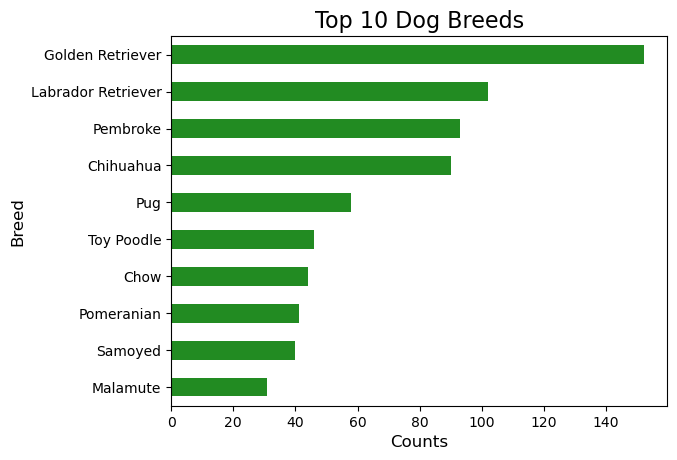

In [111]:
top_10_breeds = twitter_archive_master['dog_type'].value_counts()[0:10].sort_values(axis=0, ascending=True)
top_10_breeds.plot(kind = 'barh', color=['forestgreen'])
plt.title('Top 10 Dog Breeds', size=16)
plt.xlabel('Counts', size=12)
plt.ylabel('Breed', size=12)
plt.savefig('top-breeds.png');

The figure above shows the top 10 dog breeds with the most tweets, and the Golden Retriever emerged as the top-most breed with 152 tweets about the breed.

### Insights 2:
##### Which is the common source of tweets?<a id="insight2"></a>

In [112]:
# using the value count function to determine the origin of tweets and defining it as 'sources'
sources = twitter_archive_master['source'].value_counts()
sources

Twitter for iPhone    1648
Twitter Web Client      22
TweetDeck                8
Name: source, dtype: int64

In [113]:
# finding their corresponding proportions and defining it as 'sources_proportion'
sources_proportion = (100. * sources / sources.sum()).round(1).astype(str) + '%'
sources_proportion

Twitter for iPhone    98.2%
Twitter Web Client     1.3%
TweetDeck              0.5%
Name: source, dtype: object

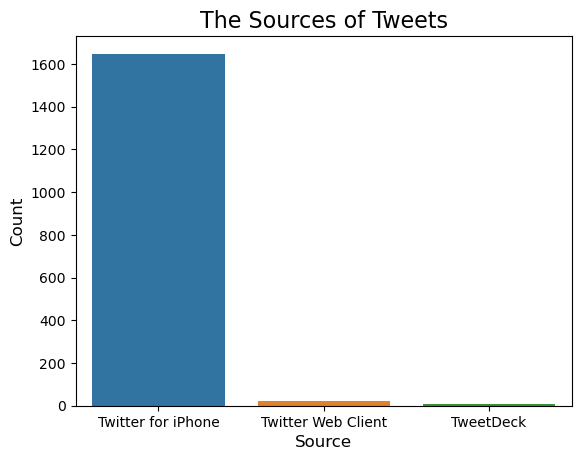

In [114]:
# plot of the number of tweets by source
common_source = twitter_archive_master['source'].value_counts()[1:5].index
sns.countplot(data = twitter_archive_master, x = 'source')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('The Sources of Tweets',fontsize=16)
plt.savefig('tweet_sources.png');

The source with the most tweets is the Twitter for iPhone taking up 1703 (98.2%) of the analysed tweet data.

### Insights 3:
##### Which year and month had the most tweet?<a id="insight3"></a>

In [115]:
# Month data
month = pd.DatetimeIndex(twitter_archive_master['timestamp']).month

In [116]:
month.value_counts().sort_index(ascending = True)

1     200
2     155
3     149
4      84
5      84
6     109
7     123
8      47
9      56
10     60
11    271
12    340
Name: timestamp, dtype: int64

In [117]:
# Year data
year = pd.DatetimeIndex(twitter_archive_master['timestamp']).year

In [118]:
year.value_counts()

2016    847
2015    514
2017    317
Name: timestamp, dtype: int64

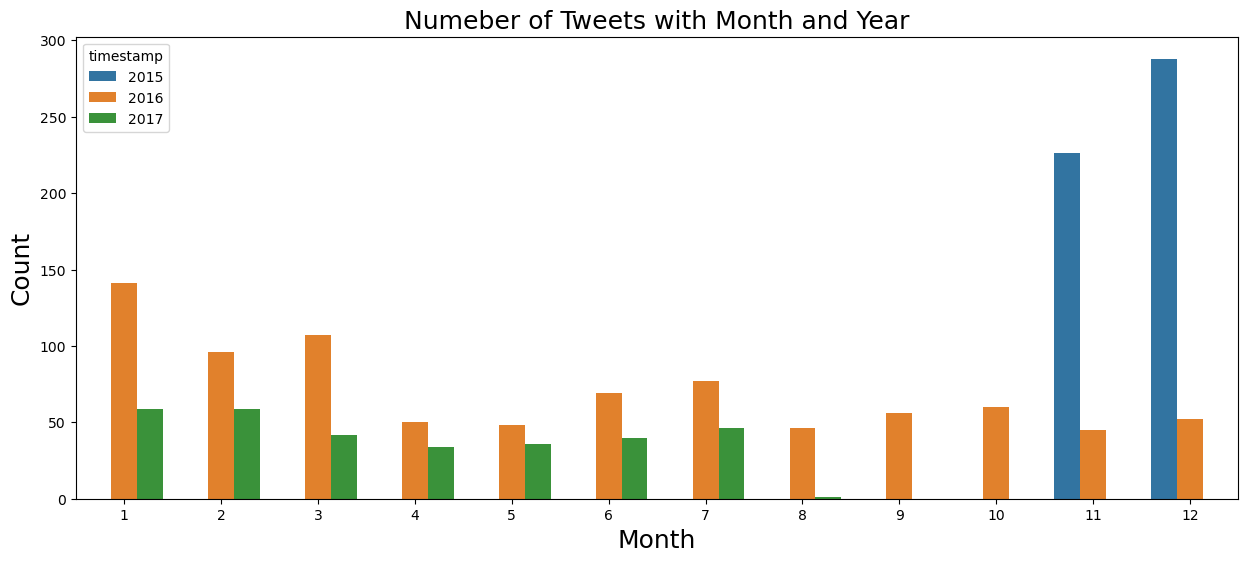

<Figure size 640x480 with 0 Axes>

In [119]:
# Histogram of number of tweets by month and year
plt.figure(figsize=(15,6))
sns.countplot(data=twitter_archive_master, x=month, hue=year)
plt.xlabel("Month", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Numeber of Tweets with Month and Year", fontsize=18)
plt.show()
plt.savefig('tweetdistr_yr_month.png');

### Insights 4:

##### Correlation between Retweets and Favorites counts (if the post is retweeted more times, it will get more visibility).<a id="insight4"></a>

In [120]:
# find the coefficient of correlation between retweet count and favorite count
retweet_favorite_corr = twitter_archive_master['retweet_count'].corr(twitter_archive_master['favorite_count'])
retweet_favorite_corr

0.9303494991105731

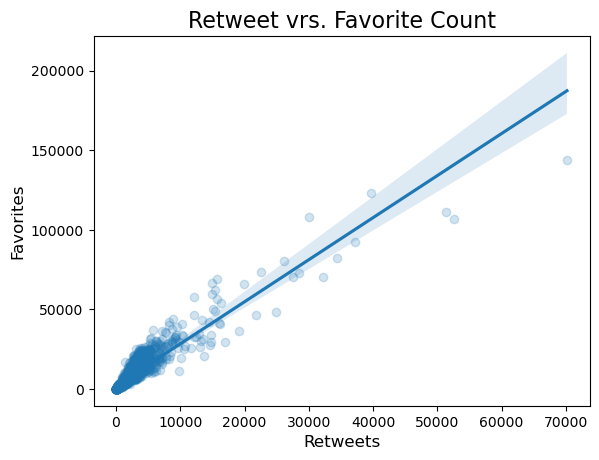

In [121]:
# plot the correlation between retweet count and favorite count
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_archive_master, scatter_kws={'alpha':0.2})
plt.title('Retweet vrs. Favorite Count', size=16)
plt.xlabel('Retweets', size=12)
plt.ylabel('Favorites', size=12)
plt.savefig('RetweetVrsFavs.png');

There is strong positive correlation at a coefficience level of 0.93 between favorite and retweet counts.

### Insights 5:

##### Correlation between Ratings and Favorites counts (whether or not higher rated dogs are more likely to receive more likes).<a id="insight5"></a>

In [122]:
# find the coefficient of correlation between ratings and favorite count
rating_favorite_corr = twitter_archive_master['rating_numerator'].corr(twitter_archive_master['favorite_count'])
rating_favorite_corr

0.06101811196715527

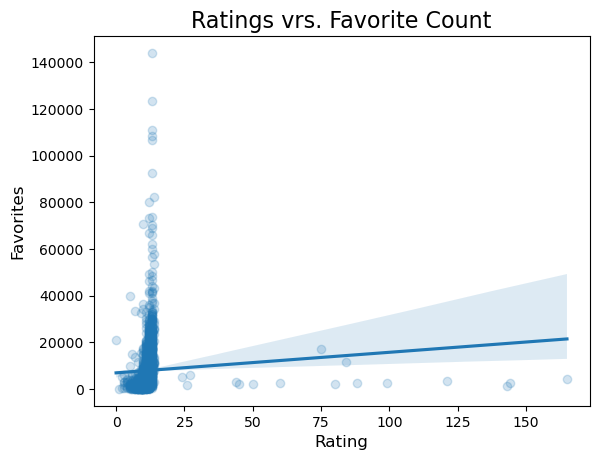

In [123]:
# plot the correlation between ratings and favorite count
sns.regplot(x="rating_numerator", y="favorite_count", data=twitter_archive_master, scatter_kws={'alpha':0.2})
plt.title('Ratings vrs. Favorite Count', size=16)
plt.xlabel('Rating', size=12)
plt.ylabel('Favorites', size=12);
plt.savefig('RatingVrsFavs.png');

With 0.06 as the correlation coefficient between ratings and retweet counts, there correlation is a very weak, yet positive.

### Insights 6:

##### Correlation between Ratings and Retweet counts (whether or  not higher rated dogs are more likely to get retweeted).<a id="insight5"></a>

In [124]:
# find the coefficient of correlation between ratings and retweet count
rating_retweet_corr = twitter_archive_master['rating_numerator'].corr(twitter_archive_master['retweet_count'])
rating_retweet_corr

0.047745440916093

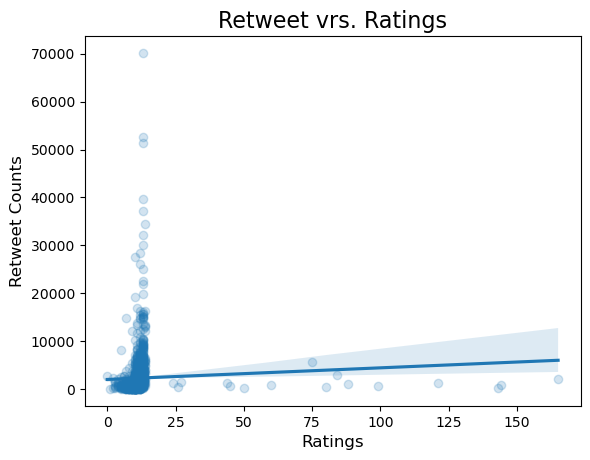

In [125]:
# plot the correlation between rating_numerator and retweet count
sns.regplot(x="rating_numerator", y="retweet_count", data=twitter_archive_master, scatter_kws={'alpha':0.2})
plt.title('Retweet vrs. Ratings', size=16)
plt.xlabel('Ratings', size=12)
plt.ylabel('Retweet Counts', size=12)
plt.savefig('RateVrsRetwee.png');

There is a weak correlation between ratings and retweets, it is positive. The coefficient of correlation is 0.05.

## References / Materials Consulted<a id="ref"></a>

1. O'Reilly - Python for Data Analysis (2nd Ed.) (2018) by Wes McKinney.<br>
2. Al Sciences - Data Analysis from Scratch with Python (2016) by Peters Morgan.<br>
3. WeRateDogs project- Part II Data cleaning and Data analysis [here](https://rachelchen0104.medium.com/weratedogs-project-part-ii-data-cleaning-and-data-analysis-b1ea2811d98b)<br>
4. weratedogs data wrangling [here](https://www.kaggle.com/code/catherinenewcomb/weratedogs-data-wrangling)<br>
5. Twitter Analytics: “WeRateDogs” - A Data Wrangling and Analysis Blog [here](https://towardsdatascience.com/twitter-analytics-weratedogs-a441be7d4a85)<br>
6. We Rate Dogs’: Twitter Data Analysis - Udacity Data Analyst ND Data Wrangling Project Write Up [here](https://medium.com/ub-women-data-scholars/we-rate-dogs-twitter-data-analysis-672e1a8903b4)<br>